In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
from haloclustering.models import Model
from haloclustering.data import get_combined_dataset
import haloclustering.evalulate_model as evaluate
from haloclustering import r_cgm
from astropy.cosmology import Planck15 as cosmo
import casbah.gal_properties as caprop
# import glob
# from cgmsquared import clustering as cgm2_cluster
# from cgmsquared import load_cgmsquared
# import cgmsquared.clustering2 as c2
# from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
import corner
import pickle
import os

In [2]:
def get_pickles(onehalopklfile, twohalopklfile):
    if os.path.exists(onehalopklfile):
        
        infile = open(onehalopklfile,'rb')
        sampler = pickle.load(infile)
        infile.close()
    else:
        print(""""You need to find the output of the emcee model in 
            cluster_cgm3_2_powerlaws_sum_with_2betas_2gammas.ipynb or rerun it""")

    # get the > 1Mpc fit "2h_only"
    if os.path.exists(twohalopklfile):
        
        infile = open(twohalopklfile,'rb')
        sampler_2h_only = pickle.load(infile)
        infile.close()
    else:
        print(""""You need to find the output of the emcee model in 
            cluster_cgm3_only_1Mpc_check_dNdz.ipynb or rerun it""") 

    return sampler, sampler_2h_only

def log_probability(theta, *args):
    return None


# load in the data and posterior samples 

In [3]:
onehalopklfile = "model_rvir_as_r0_sampler.pkl"
twohalopklfile = "2h_only_1Mpc_full_sampler.pkl"
#cgmsqfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos10_3sigma.json"
#casdir = "/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits"
# data = get_combined_dataset(cgmsqfile, casdir)
sampler, sampler_2h_only = get_pickles(onehalopklfile, twohalopklfile)
flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)
flat_samples_2h_only = sampler_2h_only.get_chain(discard=2000, thin=1, flat=True)

In [4]:
def make_grid_data(mass, redshift):
    npts = 1000
    r_lin = np.geomspace(1e-10, 20, npts)
    m_lin = np.full(npts, 10**mass)
    z_lin = np.full(npts, redshift)
    Hz_lin = cosmo.H(z_lin).value
    dv = 500.
    hits = np.ones_like(r_lin)
    misses = np.ones_like(r_lin)
    logmhalo = caprop.calchalomass(mass, redshift)
    rvir = caprop.calcrvir(logmhalo, redshift)
    do_anly = np.ones_like(r_lin)

    data = z_lin, r_lin, m_lin, hits, misses, Hz_lin, dv, rvir, do_anly 
    return data

def limits(sample):
    
    hi = np.nanquantile(sample, 0.86)
    med = np.nanquantile(sample, 0.5)
    low = np.nanquantile(sample, 0.14)
    
    return med, hi, low

In [5]:
data = make_grid_data(9.5, 0.1)

In [6]:
# instantiate the model with fake data at a single mass and redshift
rvirModel = Model(data)
# compute the distribution of R_21 at that mass and redshift
r21_sample = r_cgm.compute_Rcrossing(rvirModel, flat_samples, thin=500)

In [8]:
r21_sample.mean()

1.2148595

### compute R_21 at a grid in mass and redshift

In [9]:
npts_mass = 50
npts_z = 1

mass_space = np.linspace(7, 11.5, npts_mass)
#redshift_space = np.linspace(0.1, 0.5, npts_z)
redshift_space = [0.3]

r21_realization_list = []
r21_med_list = []
r21_hi_list = []
r21_low_list = []


for redshift_i in redshift_space:
    r21_realization_list_single_redshift = []
    r21_med_list_at_single_redshift = []
    r21_hi_list_at_single_redshift = []
    r21_low_list_at_single_redshift = []
    for mass_i in mass_space:
        data_m_z = make_grid_data(mass_i, redshift_i)
        rvirModelgrid = Model(data_m_z)
        r21_sample = r_cgm.compute_Rcrossing(rvirModelgrid, flat_samples, thin=50, log=False, only_crossing=True)        
        r21_med, r21_hi, r21_low = limits(r21_sample)
             
        r21_realization_list_single_redshift.append(r21_sample)
        r21_med_list_at_single_redshift.append(r21_med)
        r21_hi_list_at_single_redshift.append(r21_hi)
        r21_low_list_at_single_redshift.append(r21_low)
    r21_realization_list.append(r21_realization_list_single_redshift)    
    r21_med_list.append(r21_med_list_at_single_redshift)
    r21_hi_list.append(r21_hi_list_at_single_redshift)
    r21_low_list.append(r21_low_list_at_single_redshift)

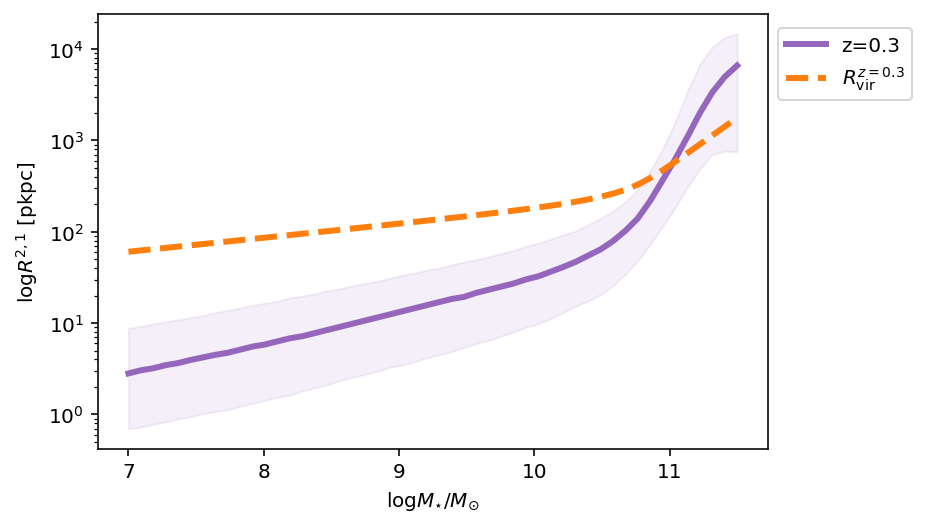

In [11]:
logmhalo_z0p3 = [
        caprop.calchalomass(mstar, 0.3)
        for mstar in mass_space]

rvir_z0p3 = np.array([caprop.calcrvir(mh, 0.3) for mh in logmhalo_z0p3])
color=["tab:purple", "tab:blue"]
for idx, z in enumerate(redshift_space):
    plt.plot(mass_space, r21_med_list[idx], label=f'z={z}', lw=3, color=color[idx])
    plt.fill_between(mass_space, r21_low_list[idx], r21_hi_list[idx], color=color[idx],
                     alpha=0.1)
    
plt.plot(mass_space, rvir_z0p3, ls='--', lw=3, 
         label=r'$R_{\rm vir }^{z=0.3}$', c='tab:orange')

plt.yscale('log')
plt.xlabel(r'log$M_{\star}/M_{\odot}$');
plt.ylabel(r'log$R^{2,1}$ [pkpc]')
plt.legend(bbox_to_anchor=(1, 0.99));